## Phase diagram on composition plane

Phase diagram on composition plane $(\phi_A, \phi_B)$ with given $\eta_{SS'}$, $\rho_S$, $\bar{\rho}_S$. Here, $\omega_{SS'}$ becomes

$$
\omega_{SS'} = \frac{\phi_S}{\bar{v}_S} \left.\frac{\partial v_{S}}{\partial \rho_{S'}}\right|_{\{\phi_S\}},
$$
where $\bar{v}_S = v_S(\phi_A, \phi_B)$ and $v_S$ is determined by
$$
v_S(\rho_A(\mathbf{r}), \rho_B(\mathbf{r})) = v_{S,0} \tilde{v}_{SA}(\rho_A(\mathbf{r}))\tilde{v}_{SB}(\rho_B(\mathbf{r})),
$$
with
$$
\begin{aligned}
\tilde{v}_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right).
\end{aligned}
$$
Then
$$\omega_{SS'}=\frac{\phi_S}{\tilde{v}_{SS'}(\phi_{S'})} \tilde{v}_{SS'}'(\phi_{S'}),$$
where
$$
\begin{aligned}
\tilde{v}_{SA}'(\rho_A)&=\partial_{\rho_A} \tilde{v}_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'(\rho_B)&=\partial_{\rho_B} \tilde{v}_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

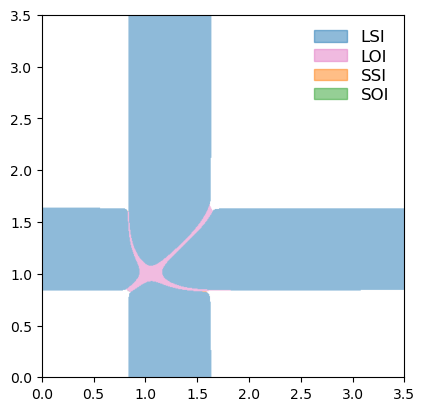

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as mpatches
import os

from cal_omega_barV import get_bar_v_omega
from general_PD import find_long_instabi, find_short_instabi, find_contours


def get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA=1, bar_vB=1, kappa=0.7,
                            extent=[0, 4, 0, 4], qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=3./20, simple_gamma=False):
    if simple_gamma:
        folder = "data/PD_pA_pB_SG/"
    elif ll == 0.:
        folder = "data/PD_pA_pB_woS/"
    else:
        folder = "data/PD_pA_pB/"
    fout = "%se%g_%g_%g_%g_D%g_%g_r%g_%g_v%g_%g_qm%g_r%g.npz" % (
        folder, etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax, resolution
    )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        pA = np.linspace(extent[0], extent[1], ncols)
        pB = np.linspace(extent[2], extent[3], nrows)
        pA_2D, pB_2D = np.meshgrid(pA, pB)
        vA_0, vB_0, wAA, wAB, wBA, wBB = get_bar_v_omega(
            etaAA, etaAB, etaBA, etaBB, pA_2D, pB_2D, bar_rho_A, bar_rho_B, bar_vA, bar_vB, kappa)
        w1 = 1 + wAA
        w2 = 1 + wBB
        wc = wAB * wBA
        sigma_D = Dr_A / Dr_B
        sigma_v = vA_0 / vB_0
        Pe = vB_0 / Dr_B

        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=qmin, ll=ll, simple_gamma=simple_gamma)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
            for col in range(ncols):
                if mask_LS[row, col]:
                    q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                        sigma_D, sigma_v[row, col], Pe[row, col], w1[row, col], w2[row, col], wc[row, col], qmin=qmin, qmax=qmax, Nq=Nq, ll=ll, simple_gamma=simple_gamma)
        state = np.zeros((nrows, ncols), dtype=np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_composition(state, extent, xlim=None, ylim=None, ax=None, fill=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:blue", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:blue", lw=1)
    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:green", lw=1)
    # # ax.plot(1, 1, "o", ms=2, c="k")

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()


def plot_state(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape

    colors = np.zeros((nrows, ncols, 3), int)
    colors[state==0] = np.array([255,255,255])
    colors[state==1] = np.array([142,186,217])
    colors[state==2] = np.array([241,187,224])
    colors[state==3] = np.array([255,190,134])
    colors[state==4] = np.array([149,207,149])


    im = ax.imshow(colors, origin="lower", extent=extent)

    patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
               mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
               mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5),
               mpatches.Patch(color='tab:green', label='SOI', alpha=0.5),
            ]
    ax.legend(handles=patches, loc="upper right", fontsize="large", frameon=False, labelspacing=0.25)

    # ax.plot(3/40, 56/40, "o")
    # ax.plot([5.92/40, 1.95/40], [27.13/40, 66.6/40], ":s")

    
    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()

def plot_PD_composition_Turing(state, extent, xlim=None, ylim=None, ax=None, fill=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    x_center = None
    y_center = None
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        
        if fill:
            if x[0] == x[-1]:
                ax.fill(x, y, c="tab:blue", alpha=0.5)
            else:
                if x_center is None:
                    x_center = x
                    y_center = y
                else:
                    if y[0] != y_center[0]:
                        x_center = np.hstack((x_center, x))
                        y_center = np.hstack((y_center, y))
                    else:
                        x_center = np.hstack((x_center, x[::-1]))
                        y_center = np.hstack((y_center, y[::-1]))
        else:
            ax.plot(x, y, c="tab:blue", lw=1)
    if fill:
        ax.fill(x_center, y_center, c="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:green", lw=1)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()


Dr_A = Dr_B = 0.1
etaAA = -2
etaBB = -2
# etaAB = 0.95
# etaBA = -0.05

etaAB = 0.99
etaBA = -0.01
bar_rho_A = 1
bar_rho_B = 1
bar_vA = 1
bar_vB = 1
# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=600)
# plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])

plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])


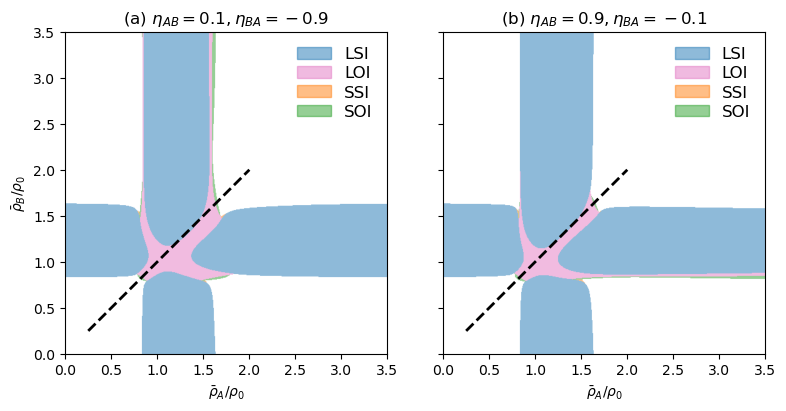

In [2]:
Dr_A = Dr_B = 0.1
etaAA = -2
etaBB = -2


etaAB = 0.1
etaBA = -0.9
bar_rho_A = 1
bar_rho_B = 1
bar_vA = 1
bar_vB = 1
# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=600)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)
plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5], ax=ax1)


etaAB = 0.9
etaBA = -0.1
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=600)
plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5], ax=ax2)

x = np.linspace(0.25, 2)
ax1.plot(x, x, "--", lw=2, c="k")
ax2.plot(x, x, "--", lw=2, c="k")


ax1.set_xlabel(r"$\bar{\rho}_A/\rho_0$")
ax2.set_xlabel(r"$\bar{\rho}_A/\rho_0$")
ax1.set_ylabel(r"$\bar{\rho}_B/\rho_0$")

ax1.set_title(r"(a) $\eta_{AB}=0.1, \eta_{BA}=-0.9$")
ax2.set_title(r"(b) $\eta_{AB}=0.9, \eta_{BA}=-0.1$")

plt.show()
plt.close()


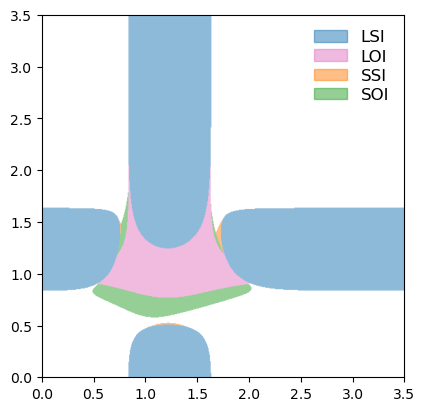

In [3]:
Dr_A = Dr_B = 0.1
etaAA = -2
etaBB = -2
etaAB = 2
etaBA = -2
bar_rho_A = 1
bar_rho_B = 1
bar_vA = 1
bar_vB = 1

# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=600)
# plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])
plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])

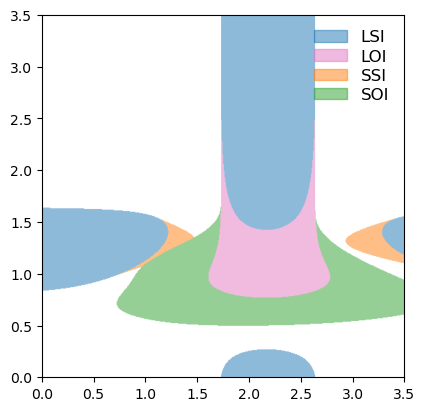

In [4]:
Dr_A = Dr_B = 0.1
etaAA = -0.5 
etaBB = -2
etaAB = 2
etaBA = -0.5
bar_rho_A = 1
bar_rho_B = 1
bar_vA = 2
bar_vB = 0.5

# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=600)
# plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])
plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])

0.0
0.12899171067159615


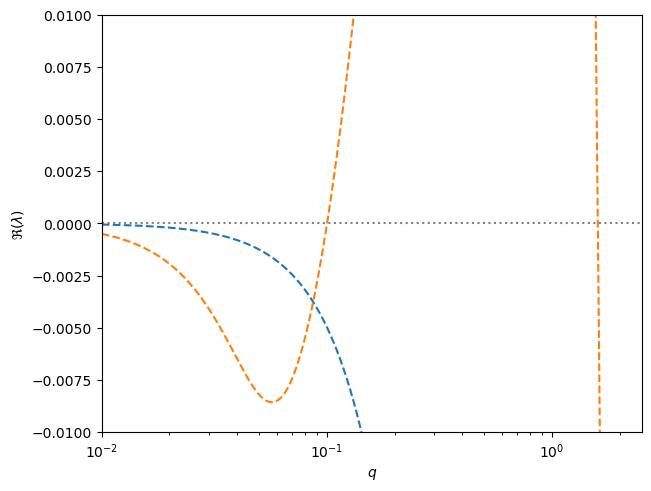

In [5]:
from NRQS_Turing import DMatrix_w_surface_tension, DMatrix

# q_arr = np.linspace(1e-6, np.sqrt(20/3), 1000)
q_arr = np.logspace(-2, np.log10(np.sqrt(20/3)), 10000, endpoint=False)

def plot_lambda(x, y, ax, threshold=1e-8):
    print(np.max(y.real))
    mask_r = np.abs(y.imag) <= threshold
    turning_pts = [0]
    states = [mask_r[0]]
    for i in range(x.size):
        if states[-1] != mask_r[i]:
            turning_pts.append(i)
            states.append(mask_r[i])
    turning_pts.append(x.size)
    line = None
    for i, s in enumerate(states):
        beg, end = turning_pts[i], turning_pts[i+1]
        xx = x[beg:end]
        yy = y[beg:end].real
        if s:
            ls = "-"
        else:
            ls = "--"
        if line is None:
            line, = ax.plot(xx, yy, ls)
        else:
            ax.plot(xx, yy, ls, c=line.get_c())

Dr_A = Dr_B = 0.1
etaAA = 0
etaBB = 0
etaAB = 1.5
etaBA = -1.5
# bar_rho_A = 6/40
# bar_rho_B = 30/40
bar_rho_A = 1
bar_rho_B = 1
bar_vA = 1
bar_vB = 1

# phiA = 5.92/40
# phiB = 27.13/40

phiA = 1
phiB = 1

M1 = DMatrix_w_surface_tension(etaAA, etaAB, etaBA, etaBB,
                              phiA=phiA, phiB=phiB, Dr_A=1, Dr_B=1, bar_rhoA=bar_rho_A, bar_rhoB=bar_rho_B, bar_vA=bar_vA, bar_vB=bar_vB)
M2 =DMatrix(etaAA, etaAB, etaBA, etaBB, phiA, phiB, Dr_A, Dr_B, bar_rho_A, bar_rho_B)
# mask_q = np.logical_and(q_arr < 2, q_arr>1.4e-2)
# q_arr = q_arr[mask_q]
# lamb = lamb[mask_q]
# mask_r = np.abs(lamb.imag) <= 1e-8
# mask_i = mask_r == False

# line, = plt.plot(q_arr[mask_r], lamb[mask_r].real)
# plt.plot(q_arr[mask_i], lamb[mask_i].real , "--", c=line.get_c())
# line, = plt.plot(q_arr, np.abs(lamb.imag) * Dr[i], c=c_list[i])


fig, ax = plt.subplots(1, 1, constrained_layout=True)

lamb1 = M1.get_lambda_q(q_arr).max(axis=1)
plot_lambda(q_arr, lamb1, ax)

lamb2 = M2.get_lambda_q(q_arr).max(axis=1)
plot_lambda(q_arr, lamb2, ax)

ax.set_ylim(-0.01, 0.01)
ax.set_xlim(1e-2, 2.5)
ax.set_xscale("log")
ax.axhline(0, c="tab:grey", linestyle="dotted")
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\Re(\lambda)$")
plt.show()
plt.close()

KeyboardInterrupt: 

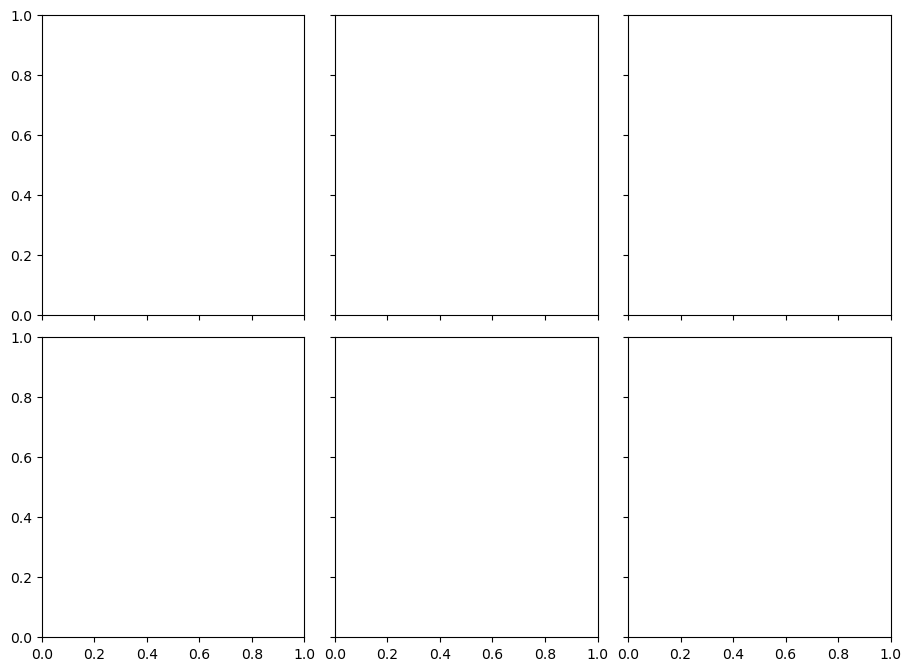

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6.6), constrained_layout=True, sharex=True, sharey=True)
Dr_A_arr = np.array([0.1, 0.5, 1, 2, 3, 6])

for i, ax in enumerate(axes.flat):
    Dr_A = Dr_A_arr[i]
    Dr_B = Dr_A * 2
    bar_vA = 8
    bar_vB = 1
    etaAA = -0.9725
    etaBB = -1.5091
    etaAB = -0.25
    etaBA = -0.25** 2 / etaAB
    # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
    extent = [0, 3, 0, 3]
    extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, 1, 1, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=2000, extent=extent)
    plot_PD_composition_Turing(state, extent, xlim=[0, 3], ylim=[0, 3], ax=ax, fill=True)

    if i // 3 == 1:
        ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    if i % 3 == 0:
        ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_title(r"$D_A^{\rm R}=%g$" % Dr_A)
    # ax.plot(1, 1, "x", c='k', ms=1)

patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
        mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
        mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5),
        mpatches.Patch(color='tab:green', label='SOI', alpha=0.5)
        ]
legend = axes[0, 0].legend(handles=patches, loc=(0.02, 0.68), fontsize="large", labelspacing=0.25, frameon=False, borderpad=0.01)
fig.suptitle(r"$\eta_{AA}=-0.9725,\eta_{BB}=-1.5091,\chi=-0.25^2, \bar{v}_A=8,\bar{v}_B=1, D_B^{\rm R}=2D_A^{\rm R}$", fontsize="x-large")
plt.show()
# plt.savefig("fig/PD_Turing_varied_DrA.pdf")
plt.close()

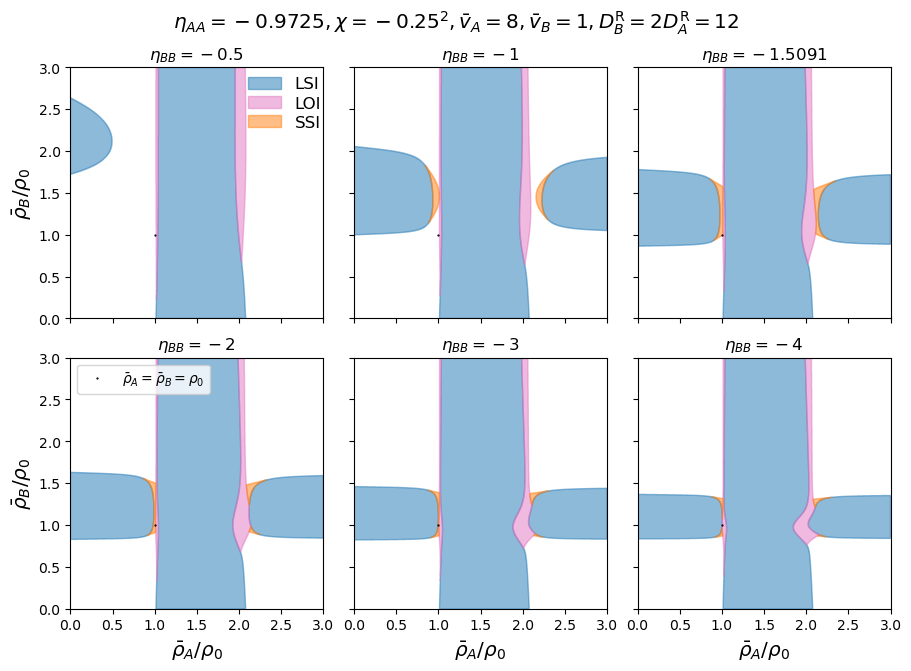

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6.6), constrained_layout=True, sharex=True, sharey=True)
eta_BB_arr = np.array([-0.5, -1, -1.5091, -2, -3, -4])

for i, ax in enumerate(axes.flat):
    Dr_A = 6
    Dr_B = Dr_A * 2
    bar_vA = 8
    bar_vB = 1
    etaAA = -0.9725
    etaBB = eta_BB_arr[i]
    etaAB = -0.25
    etaBA = -0.25** 2 / etaAB
    # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
    extent = [0, 3, 0, 3]
    extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, 1, 1, bar_vA, bar_vB, qmax=2.5, Nq=400, resolution=2000, extent=extent)
    plot_PD_composition_Turing(state, extent, xlim=[0, 3], ylim=[0, 3], ax=ax, fill=True)

    if i // 3 == 1:
        ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    if i % 3 == 0:
        ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_title(r"$\eta_{BB}=%g$" % etaBB)
    ax.plot(1, 1, "o", c='k', ms=0.6, label=r"$\bar{\rho}_A=\bar{\rho}_B=\rho_0$")
    if i == 3:
        ax.legend(loc="upper left")
    

patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
        mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
        mpatches.Patch(color='tab:orange', label='SSI', alpha=0.5)
        # mpatches.Patch(color='tab:green', label='LOI', alpha=0.5)
        ]
legend = axes[0, 0].legend(handles=patches, loc=(0.7, 0.75), fontsize="large", labelspacing=0.25, frameon=False, borderpad=0.01)
fig.suptitle(r"$\eta_{AA}=-0.9725,\chi=-0.25^2, \bar{v}_A=8,\bar{v}_B=1, D_B^{\rm R}=2D_A^{\rm R}=12$", fontsize="x-large")
plt.show()
# plt.savefig("fig/PD_Turing_varied_etaBB.pdf")
plt.close()